In [1]:
import intake
import shapely
import pandas
import geopandas
cat = intake.open_catalog('../catalogs/catalog.yml')

In [2]:
care = cat.care.read()
tracts = cat.la_geohub.census_tracts.read()

homeless_2019 = cat.la_geohub.homeless_2019.read()
homeless_2019['Tract_N'] = homeless_2019.Tract_N.astype('str')

/opt/conda/lib/python3.7/site-packages/dask/core.py:118: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


In [3]:
def point_from_location(row):
    if pandas.isna(row.Latitude) or pandas.isna(row.Longitude):
        return None
    return shapely.geometry.Point(row.Longitude, row.Latitude)
    
care['geometry'] = care.apply(point_from_location, axis=1)
care = geopandas.GeoDataFrame(care, geometry='geometry')

In [4]:
merged = geopandas.sjoin(
    care,
    tracts,
    how='inner',
    op='within',
)

/opt/conda/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [5]:
counts = merged.groupby('TRACTCE10').size().reset_index(name='CARE')

In [6]:
care_tracts = tracts.merge(
    homeless_2019.drop('geometry', axis=1), 
    left_on='TRACTCE10',
    right_on='Tract_N',
    how='left',
).merge(
    counts,
    on='TRACTCE10',
    how='left',
)

In [7]:
care_tracts['ratio'] = care_tracts.apply(
    lambda x: x.CARE / x.totPeopl_1 if x.totPeopl_1 else 0,
    axis=1
)

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


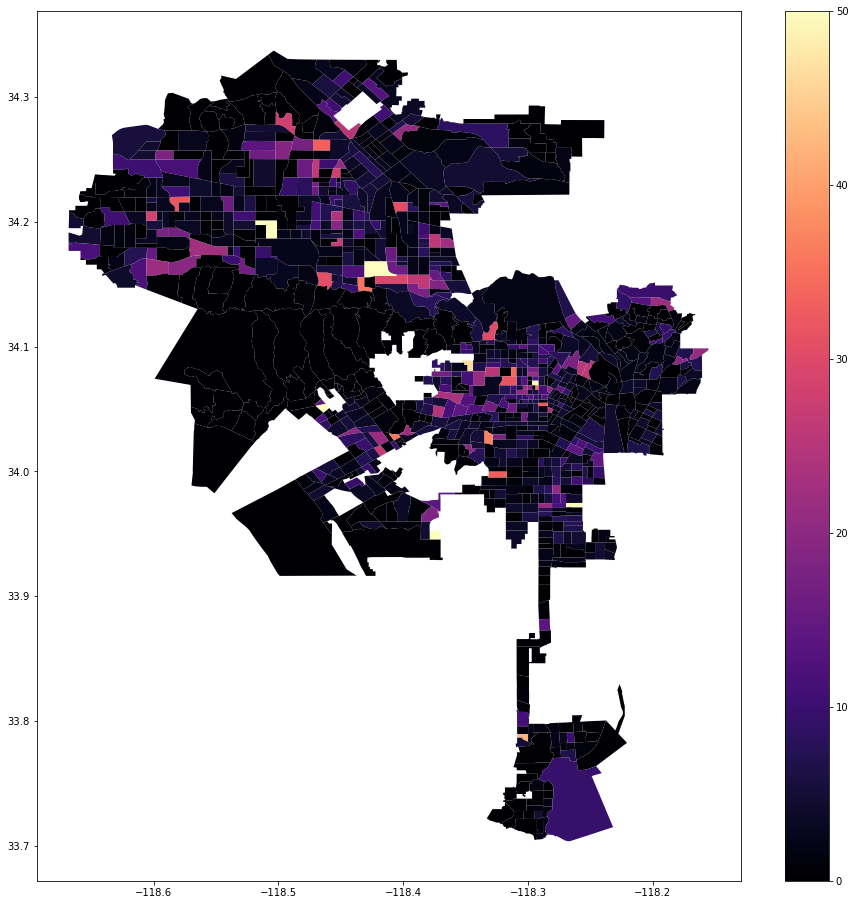

In [8]:
care_tracts.plot(
    figsize=(16,16),
    column='ratio',
    cmap='magma',
    legend=True,
    vmin=0,
    vmax=50,
)

In [9]:
import ipyleaflet
import json
from ipywidgets import Text, HTML
from branca.colormap import linear

In [10]:
df = care_tracts[['geometry', 'ratio', 'TRACTCE10']].dropna(subset=['ratio']).copy()
df = df.set_index('TRACTCE10')

choro_data = df['ratio'].dropna().to_dict()
geo_data = json.loads(df.to_json())

In [11]:
m = ipyleaflet.Map(basemap=ipyleaflet.basemaps.CartoDB.Positron)
layer = ipyleaflet.Choropleth(
    geo_data=geo_data,
    choro_data=choro_data,
    colormap=linear.viridis,
    border_color='black',
    style={
        'fillOpacity': 0.6,
        'weight': 0.6,
        'opacity': 0.6,
    },
    hover_style = {
    'fillOpacity': 0.8
    },
)


html = HTML('''
    Hover over a tract
''')
html.layout.margin = '0px 10px 10px 10px'


def update_html(feature, id, **kwargs):
    html.value = '''
        Census Tract:  
        <b>{}</b> <br>
        CARE requests/population:
        {} 
    '''.format(id, feature['properties']['ratio'])

layer.on_hover(update_html)
layer.value_max=50
layer.value_min=0

control = ipyleaflet.WidgetControl(widget=html, position='topright')
m.add_layer(layer)
m.add_control(control)

m.center = [34.067449577393475, -118.37219238281251]
m.zoom = 10

m

Map(basemap={'url': 'http://c.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png', 'max_zoom': 20, 'attribution':…